Факторизационные машины были представлены Стефаном Рендлом в 2010 году (https://www.zotero.org/ihun/items/itemKey/HID8DGWV). В своей основе они представляют из себя линейную регрессионную модель с дополнительным элементом, моделирующим взаимодействия между переменными при помощи латентных факторов.

Давайте вначале вспомним, что регрессионная модель представляет собой сумму произведений признаков на их веса:
$$y=w_0 + \sum_{i=1}^{n}w_ix_i$$

Эта модель, однако, не ухватывает взаимодействия между признаками. Обычно такое взаимодействие моделируется умножением признаков, мультипликативный эффект которых мы хотим включить в модель. Для модели второго порядка, которая прослеживает взаимодействие только между парами, но уже не тройками переменных, уравнение будет выглядеть следующим образом:
$$y=w_0 + \sum_{i=1}^{n}w_ix_i+\sum_{i=1}^{n}\sum_{j=i+1}^{n}w_{ij}x_ix_j.$$
Например, если моделируя влияение дохода (предиктор $x_{income}$) на счастье (целевая переменная $y_{happiness}$) мы считаем, что это влияние неодинаково для мужчин и для женщин и хотим учесть его в модели, то надо всего лишь добавить в уравнение ещё одно слагаемое — произведение бинарного признака "пол" на "доход": $y_{happiness}=x_{income}+x_{gender}\times x_{income}$.

С таким подходом, однако, есть одна сложность — исследователю необходимо самостоятельно генерировать новые признаки, для чего необходимо или экспертное знание комбинации признаков, мультипликативный эффект между которыми значимо улучшит модель, или время и память на перебор всех возможных пар (а иногда и троек) и подсчёт их весов, что затруднительно, если количество признаков превышает несколько сотен или тысяч штук (а оно будет превышать из-за того, что в линейных моделях необходимо перекодировать категориальные переменные по схеме dummy encoding). Поскольку число сочетаний из $n$ оббъектов по $k$ рассчитывается по формуле $C_n^k=\frac{n!}{(n-k)!\cdot k!}$, то для модели второго порядка количество параметров будет составлять $\frac{n(n − 1)}{2} + n + 1$, т.е. число весов $w_{i,j}$ растет примерно пропорционально квадрату числа базовых признаков.

К тому же данные могут быть сильно разрежены, что означает отсутствие информации о взаимодействии многих пар признаков и трудности в моделировании мультипликативных эффектов.

Факторизационные машины решают эти проблемы. Они моделируют эффекты взаимодействия между всеми признаками, но не напрямую перемножая их, а обучая для каждого признака вектор низкой размерности и производя скалярное произведение векторов. Итоговая формула выглядит следующим образом:
$$y=w_0 + \sum_{i=1}^{n}w_ix_i+\sum_{i=1}^{n}\sum_{j=i+1}^{n}\langle v_i,v_j\rangle x_ix_j.$$


Как видно, эта формула имеет одно отличие от предыдущей — веса $w_{ij}$ для мультипликативых эффектов признаков $i$ и $j$ заменены скалярным произведением соответствующих им векторов $v_i$ и $v_j$. Эти вектора имеют размерность k, т.е. $v_i=(u_{i1},u_{i2}\dots u_{ik})$, и чем больше размерность — более глубокие взаимодействия выучит модель, но также затратит на это больше времени и с большей вероятностью переобучится.

Помимо того, что получившиеся вектора в сжатом виде передают взаимодействия между признаками, они обладают её одним важным свойством — чем более они близки, тем более связаны признаки, которые они представяют. Результатом скалярного произведение векторов $\langle v_i,v_j\rangle$ как раз и является число, представляющее степень этой близости. Для задачи класификации, например, это будет означать, что если определённые признаки часто встречаются в одних и тех же классах, то их вектора будут более близки (а скалярное произведение больше), чем вектора других признаков.

Другое преимущество такой замены состоит в уменьшении количества параметров до числа $nk + n + 1$, где $k$ — размерность векторов $v$.

Количество товаров составляет уже $nk + n + 1$, где $k$ — количество скрытых факторов.

Выполнение за линейное время

$$\begin{split}\begin{aligned}
&\sum_{i=1}^d \sum_{j=i+1}^d \langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j \\
 &= \frac{1}{2} \sum_{i=1}^d \sum_{j=1}^d\langle\mathbf{v}_i, \mathbf{v}_j\rangle x_i x_j - \frac{1}{2}\sum_{i=1}^d \langle\mathbf{v}_i, \mathbf{v}_i\rangle x_i x_i \\
 &= \frac{1}{2} \big (\sum_{i=1}^d \sum_{j=1}^d \sum_{l=1}^k\mathbf{v}_{i, l} \mathbf{v}_{j, l} x_i x_j - \sum_{i=1}^d \sum_{l=1}^k \mathbf{v}_{i, l} \mathbf{v}_{j, l} x_i x_i \big)\\
 &=  \frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d \mathbf{v}_{i, l} x_i) (\sum_{j=1}^d \mathbf{v}_{j, l}x_j) - \sum_{i=1}^d \mathbf{v}_{i, l}^2 x_i^2 \big ) \\
 &= `\frac{1}{2} \sum_{l=1}^k \big ((\sum_{i=1}^d \mathbf{v}_{i, l} x_i)^2 - \sum_{i=1}^d \mathbf{v}_{i, l}^2 x_i^2)
 \end{aligned}\end{split}$$


Данная модель является обобщением моделей с матричными разложениями.
Выше мы обсуждали пример построения рекомендаций песен пользователям — интерес пользователя к песне оценивался как скалярное произведение некоторых скрытых векторов. Эту задачу можно сформулировать как задачу построения регрессии
с двумя категориальными признаками: идентификатором пользователя и идентификатором композиции. Целевым признаком является число прослушиваний композиции пользователем. Для некоторого подмножества пар (пользователь, композиция)
мы знаем число прослушиваний; для остальных мы хотим его восстановить. После
бинаризации признаков мы получим, что факторизационная машина оценивает целевую переменную как произведение скрытых векторов пользователя и композиции — иными словами, она строит разложение матрицы прослушиваний X.

In [3]:
from torch.nn import Module, Embedding, Parameter, Linear
from torch.nn import MSELoss, CrossEntropyLoss
from torch.optim import Adam
from sklearn.metrics import r2_score

import numpy as np
import torch
import torch.nn.functional as F
import pandas as pd

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/shenweichen/DeepCTR-Torch/master/examples/criteo_sample.txt")
df.shape

(200, 40)

In [1]:
import pandas as pd

import torch
from torch import nn, optim
from torch.functional import F

import math
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [6]:
df_dota = pd.read_csv("../../../../tmp/dota_train_binary_heroes.csv.zip")
df_dota_target = pd.read_csv("../../../../tmp/train_targets.csv.zip")

In [16]:
X = df_dota.iloc[:, 1:].values

In [11]:
y = df_dota_target[["radiant_win"]].astype(int)

In [3]:
ls ../../../../tmp/dota_train_binary_heroes.csv.zip

brands.pq       crieto.csv                        train_targets.csv.zip
brands_test.pq  dota_train_binary_heroes.csv.zip


In [29]:
df_churn = pd.read_csv("http://nagornyy.me/datasets/telco-customer-churn.zip")
df_churn.shape

(7043, 21)

In [130]:
criteo = pd.read_csv("https://raw.githubusercontent.com/shenweichen/DeepCTR/master/examples/criteo_sample.txt")

In [30]:
df_churn["TotalCharges"] = pd.to_numeric(df_churn.TotalCharges, errors="coerce")

In [33]:
df_churn["SeniorCitizen"].unique().replace({0: "No", 1: "Yes"})

array([0, 1])

In [166]:
y = df_churn.Churn.replace({"Yes": 1., "No": 0.}).values.reshape(-1, 1)

In [162]:
df_churn.select_dtypes("object").columns

Index(['customerID', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn'],
      dtype='object')

In [163]:
X = df_churn.drop(columns=["Churn", "customerID"])
X = pd.get_dummies(
    data=X,
    columns=X.select_dtypes("object").columns,
    dummy_na=True
).fillna(0)

In [80]:
X = pd.get_dummies(
    data=criteo.drop(columns="label"),
    columns=criteo.columns[criteo.columns.str.startswith("C")],
    dummy_na=True
).fillna(0)

In [2]:
!ls ../../datasets/movielens-small/

links.csv.zip  movies.csv.zip  ratings.csv.zip	README.txt  tags.csv.zip


In [104]:
df_movies = pd.read_csv("../../datasets/movielens-small/movies.csv")
df_ratings = pd.read_csv("../../datasets/movielens-small/ratings.csv")
df_tags = pd.read_csv("../../datasets/movielens-small/tags.csv")
df_links = pd.read_csv("../../datasets/movielens-small/links.csv")

In [108]:
df_links

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0
...,...,...,...
9737,193581,5476944,432131.0
9738,193583,5914996,445030.0
9739,193585,6397426,479308.0
9740,193587,8391976,483455.0


In [50]:
df_ratings['rating_bin'] = (df_ratings.rating > 3).astype("float")

In [52]:
df_ratings['rating_bin'].value_counts()

1.0    61716
0.0    39120
Name: rating_bin, dtype: int64

In [6]:
df_ratings.shape

(100836, 4)

In [9]:
df_ratings.userId.nunique(), df_ratings.movieId.nunique(), df_ratings.userId.nunique() * df_ratings.movieId.nunique()

(610, 9724, 5931640)

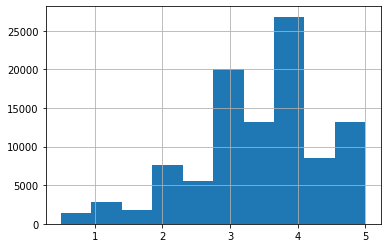

In [10]:
df_ratings.rating.hist();

In [15]:
movielens = pd.pivot(df_ratings, index="userId", columns="movieId", values="rating")
movielens.shape

(610, 9724)

In [19]:
movielens.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
# df_ratings["userId"] = df_ratings["userId"].apply(lambda x: f"userId_{x}")
# df_ratings["movieId"] = df_ratings["movieId"].apply(lambda x: f"movieId_{x}")

In [27]:
df_ratings[["userId", "movieId"]] = df_ratings[["userId", "movieId"]].astype("category")

In [28]:
ratings_onehot = pd.get_dummies(df_ratings[["userId", "movieId"]], sparse=True)

In [29]:
ratings_onehot.shape

(100836, 10334)

In [12]:
from patsy import dmatrices

# create dummy variables, and their interactions
y, interactions = dmatrices('rating ~ C(userId):C(movieId) - 1', df_ratings[:3000], return_type="dataframe")

In [13]:
interactions.shape

(3000, 35360)

In [14]:
interactions.head(1)

,C(userId)[1]:C(movieId)[1],C(userId)[2]:C(movieId)[1],C(userId)[3]:C(movieId)[1],C(userId)[4]:C(movieId)[1],C(userId)[5]:C(movieId)[1],C(userId)[6]:C(movieId)[1],C(userId)[7]:C(movieId)[1],C(userId)[8]:C(movieId)[1],C(userId)[9]:C(movieId)[1],C(userId)[10]:C(movieId)[1],...,C(userId)[11]:C(movieId)[185135],C(userId)[12]:C(movieId)[185135],C(userId)[13]:C(movieId)[185135],C(userId)[14]:C(movieId)[185135],C(userId)[15]:C(movieId)[185135],C(userId)[16]:C(movieId)[185135],C(userId)[17]:C(movieId)[185135],C(userId)[18]:C(movieId)[185135],C(userId)[19]:C(movieId)[185135],C(userId)[20]:C(movieId)[185135]
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
X_tensor = torch.from_numpy(X).float()
# interaction_data_tensor = torch.from_numpy(interactions.values).long()
y_tensor = torch.from_numpy(y.values).float()

In [95]:
X_tensor = torch.from_numpy(ratings_onehot.values[:1000]).float()
# interaction_data_tensor = torch.from_numpy(interactions.values).long()
y_tensor = torch.from_numpy(df_ratings[["rating_bin"]].values[:1000]).float()

In [23]:
class FM(nn.Module):
    def __init__(self, features_num=None, k=5):
        super().__init__()
        self.V = nn.Parameter(torch.randn(features_num, k), requires_grad=True)
        self.linear = nn.Linear(features_num, 1)

    def forward(self, X):
        out_1 = ((X @ self.V) ** 2).sum(1, keepdim=True)
        out_2 = ((X ** 2) @ (self.V ** 2)).sum(1, keepdim=True)

        out_interaction = 0.5 * (out_1 - out_2)
        out_linear = self.linear(X)
        out = out_interaction + out_linear

        return torch.sigmoid(out)

In [26]:
from torch import nn, optim

epochs = 1000
learning_rate = 0.001

model = FM(features_num=X_tensor.shape[1])
criterion = nn.BCELoss() 
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = model(X_tensor)
    loss = criterion(predictions, y_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % (epochs / 10) == 0:
        print('epoch {}, loss {}'.format(epoch, loss.item()))

epoch 99, loss 5.97332763671875
epoch 199, loss 5.958538055419922
epoch 299, loss 5.943296909332275
epoch 399, loss 5.928140163421631
epoch 499, loss 5.91276741027832
epoch 599, loss 5.8979878425598145
epoch 699, loss 5.883572578430176
epoch 799, loss 5.868875980377197
epoch 899, loss 5.853577136993408
epoch 999, loss 5.83882999420166


In [27]:
roc_auc_score(y_tensor.squeeze(1).numpy(), model(X_tensor).detach().squeeze())

0.4968278657420214

In [ ]:
# https://github.com/rixwew/pytorch-fm/blob/master/torchfm/model/fm.py

class FeaturesLinear(nn.Module):

    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.fc = nn.Embedding(sum(field_dims), output_dim)
        self.bias = nn.Parameter(torch.zeros((output_dim,)))
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return torch.sum(self.fc(x), dim=1) + self.bias


class FeaturesEmbedding(nn.Module):

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)


class FactorizationMachine(nn.Module):

    def __init__(self, reduce_sum=True):
        super().__init__()
        self.reduce_sum = reduce_sum

    def forward(self, x):
        """
        :param x: Float tensor of size ``(batch_size, num_fields, embed_dim)``
        """
        square_of_sum = torch.sum(x, dim=1) ** 2
        sum_of_square = torch.sum(x ** 2, dim=1)
        ix = square_of_sum - sum_of_square
        if self.reduce_sum:
            ix = torch.sum(ix, dim=1, keepdim=True)
        return 0.5 * ix


class FactorizationMachineModel(nn.Module):
    """
    A pytorch implementation of Factorization Machine.
    Reference:
        S Rendle, Factorization Machines, 2010.
    """

    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.linear = FeaturesLinear(field_dims)
        self.fm = FactorizationMachine(reduce_sum=True)

    def forward(self, x):
        """
        :param x: Long tensor of size ``(batch_size, num_fields)``
        """
        x = self.linear(x) + self.fm(self.embedding(x))
        return torch.sigmoid(x.squeeze(1))

In [352]:
# https://github.com/shenweichen/DeepCTR-Torch/blob/master/deepctr_torch/layers/interaction.py#L12

class FM(Module):
    """Factorization Machine models pairwise (order-2) feature interactions
     without linear term and bias.
      Input shape
        - 3D tensor with shape: ``(batch_size,field_size,embedding_size)``.
      Output shape
        - 2D tensor with shape: ``(batch_size, 1)``.
      References
        - [Factorization Machines](https://www.csie.ntu.edu.tw/~b97053/paper/Rendle2010FM.pdf)
    """

    def __init__(self):
        super().__init__()

    def forward(self, inputs):
        fm_input = inputs

        square_of_sum = torch.pow(torch.sum(fm_input, dim=1, keepdim=True), 2)
        sum_of_square = torch.sum(fm_input * fm_input, dim=1, keepdim=True)
        cross_term = square_of_sum - sum_of_square
        cross_term = 0.5 * torch.sum(cross_term, dim=1, keepdim=False)

        return cross_term

In [1]:
class TorchFM(Module):
    def __init__(self, n=None, k=None):
        super().__init__()
        # Initially we fill V with random values sampled from Gaussian distribution
        # NB: use nn.Parameter to compute gradients
        self.V = Parameter(torch.randn(n, k), requires_grad=True)
        self.lin = Linear(n, 1)


    def forward(self, x):
        out_1 = torch.matmul(x, self.V).pow(2).sum(1, keepdim=True) #S_1^2
        out_2 = torch.matmul(x.pow(2), self.V.pow(2)).sum(1, keepdim=True) # S_2

        out_inter = 0.5 * (out_1 - out_2)
        out_lin = self.lin(x)
        out = out_inter + out_lin

        return out

NameError: name 'Module' is not defined

In [354]:
cat_columns = df.columns[df.columns.str.startswith("C")]
# X = pd.get_dummies(df, columns=cat_columns, drop_first=True, dummy_na=True).fillna(0)
X = pd.get_dummies(df[cat_columns], drop_first=True, dummy_na=True)
y = df.label

X = torch.from_numpy(X.values).float()
y = torch.from_numpy(y.values).view(-1, 1).float()

In [355]:
n = X.shape[1]
k = 5

In [357]:
model = FM()

In [319]:
model = TorchFM(n=n, k=k)

In [340]:
fm_input = X

In [358]:
square_of_sum = torch.pow(torch.sum(fm_input, dim=1, keepdim=True), 2)
sum_of_square = torch.sum(fm_input * fm_input, dim=1, keepdim=True)
cross_term = square_of_sum - sum_of_square
cross_term = 0.5 * torch.sum(cross_term, dim=1, keepdim=False)

In [359]:
optimizer = Adam(model.parameters(), lr=0.01)

ValueError: optimizer got an empty parameter list

In [289]:
def chunked(X, y, chuck_size=10):
    assert len(X) == len(y)
        
    for i in range(0, len(X), chuck_size):
        yield X[i : i + chuck_size], y[i : i + chuck_size]

In [290]:
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for X_batch, y_batch in chunked(X, y, chuck_size=50):
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        print(f'epoch {epoch}, loss: {running_loss:.3f}')
        running_loss = 0.0

print('Finished Training')

epoch 0, loss: 717111294951424.000
epoch 0, loss: 8930133045936128.000
epoch 0, loss: 372798430117888.000
epoch 0, loss: 4859796297613312.000
epoch 1, loss: 717111294951424.000
epoch 1, loss: 8930133045936128.000
epoch 1, loss: 372798430117888.000
epoch 1, loss: 4859796297613312.000
Finished Training


In [241]:
from torchfm.dataset.criteo import CriteoDataset

In [261]:
citeo_data = CriteoDataset(dataset_path="../../../../tmp/crieto.csv")

In [263]:
field_dims = citeo_data.field_dims

In [266]:
model = FactorizationMachineModel(field_dims=field_dims, embed_dim=5)